## Redes Neuronales Convolucionales (Transfer Learning y Fine Tuning)

En este laboratorio, nos adentraremos en un proceso de entrenamiento de un modelo existente utilizando una técnica fundamental en aprendizaje profundo: la transferencia de conocimientos (transfer learning), junto con la técnica de fine-tuning (ajuste fino). Esta estrategia nos permitirá mejorar significativamente la precisión y el rendimiento de nuestro modelo. Vamos a proceder de la siguiente manera:

In [144]:
# importamos las librerias que vamos a utilizar en el notebook

import torch # libreria principal
import torch.nn as nn # libreria para redes neuronales
import torch.optim as optim # libreria para optimizacion
from torch.utils.data import DataLoader, Dataset # libreria para cargar los datos
import torchvision.transforms as transforms # libreria para transformar los datos
from torchvision import models # libreria para modelos pre-entrenados
from datasets import load_dataset # libreria para cargar los datos
from tqdm import tqdm # libreria para barra de progreso

### Dataset

Trabajaremos con una versión reducida del conjunto de datos ImageNet conocida como Tiny ImageNet. Esta variante incluye un conjunto de entrenamiento compuesto por 100,000 ejemplos y un conjunto de prueba de 10,000 ejemplos.

In [145]:
# cargamos el dataset de Tiny ImageNet y lo guardamos en la variable dataset
dataset_ti = load_dataset("zh-plus/tiny-imagenet")

In [146]:
# mostramos la estructura del dataset
dataset_ti

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 100000
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

### Función para graficar

Esta función se utiliza para visualizar imágenes aleatorias con el fin de tener una idea de los tipos de datos con los que estamos trabajando.

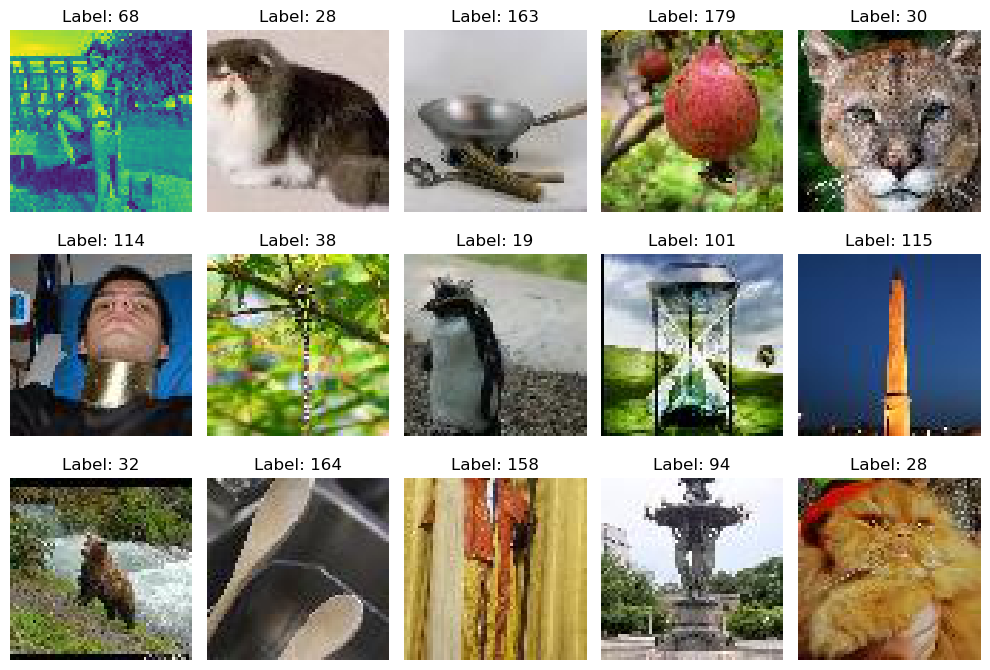

In [147]:
# graficamos algunas imagenes para saber con que tipo de datos estamos trabajando
import matplotlib.pyplot as plt
import random

def show_random_images(dataset, num_rows, num_columns):
    # Crear una figura y ejes para la tabla de imágenes
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, 7))

    for i in range(num_rows):
        for j in range(num_columns): 
            # Elegir aleatoriamente una imagen del conjunto de entrenamiento
            random_index = random.randint(0, len(dataset['train']) - 1) 
            random_image = dataset['train'][random_index]['image'] 
            random_label = dataset['train'][random_index]['label'] 

            # Mostrar la imagen en el subgráfico correspondiente
            axes[i, j].imshow(random_image, interpolation='nearest')
            axes[i, j].set_title(f"Label: {random_label}")
            axes[i, j].axis('off')  # Ocultar los ejes

    # Ajustar el espacio entre los subgráficos para que se vean bien
    plt.tight_layout()
    # Mostrar la tabla de imágenes
    plt.show()

# Llamar a la función con tu dataset
show_random_images(dataset_ti, 3, 5)


### Transformaciones 

En esta sección, implementamos algunas transformaciones que deseamos aplicar a las imágenes. En nuestro caso, estas transformaciones incluyen las siguientes:

In [148]:
from PIL import Image

class EnsureRGBChannels:
    def __call__(self, image):
        if image.mode != 'RGB':
            image = image.convert('RGB')
        return image

# Definir la transformación
transform = transforms.Compose([
    EnsureRGBChannels(),  # Asegurarse de que todas las imágenes tengan 3 canales
    transforms.Resize((64, 64)),  # Redimensionar a 64x64
    transforms.ToTensor(),  # Convertir a tensor
])

### Dataset Custom

Esta clase facilitará el manejo de nuestro conjunto de datos, simplificando las operaciones y la interacción con él.

In [149]:
# Defina su clase de conjunto de datos personalizado
class CustomDataset(Dataset):
    def __init__(self, dataset, split, transform=None):
        self.X = dataset[split]['image'] # cargar imágenes
        self.y = dataset[split]['label'] # cargar etiquetas
        self.transform = transform

    # Devuelve el número de muestras en el conjunto de datos.
    def __len__(self):
        return len(self.X)

    # Devuelve una muestra del conjunto de datos en la posición index.
    def __getitem__(self, idx):
        img = self.X[idx]
        label = self.y[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

In [150]:
# Creamos el conjunto de datos de entrenamiento y de prueba con la clase CustomDataset que definimos anteriormente 
dataset = {
    'train' : CustomDataset(dataset_ti, 'train', transform=transform),
    'test' : CustomDataset(dataset_ti, 'valid', transform=transform),
}

len(dataset['train']), len(dataset['test'])

(100000, 10000)

In [151]:
# mostrar las dimensiones de una imagen del conjunto de datos de entrenamiento
dataset['train'][0][0].shape

torch.Size([3, 64, 64])

Estamos mostrando una imagen para determinar si está normalizadas o no.

In [152]:
dataset['train'][9]

(tensor([[[0.3765, 0.3765, 0.3765,  ..., 0.3686, 0.3608, 0.3529],
          [0.3882, 0.3882, 0.3882,  ..., 0.3922, 0.3882, 0.3882],
          [0.3725, 0.3765, 0.3765,  ..., 0.4039, 0.4039, 0.4000],
          ...,
          [0.1137, 0.1961, 0.2235,  ..., 0.2510, 0.2510, 0.2510],
          [0.0784, 0.1725, 0.2118,  ..., 0.2471, 0.2471, 0.2431],
          [0.0549, 0.1608, 0.2118,  ..., 0.2471, 0.2431, 0.2431]],
 
         [[0.4235, 0.4235, 0.4235,  ..., 0.4235, 0.4157, 0.4078],
          [0.4392, 0.4392, 0.4392,  ..., 0.4510, 0.4471, 0.4471],
          [0.4314, 0.4353, 0.4353,  ..., 0.4667, 0.4667, 0.4627],
          ...,
          [0.1686, 0.2510, 0.2824,  ..., 0.2941, 0.2941, 0.2941],
          [0.1333, 0.2275, 0.2667,  ..., 0.2902, 0.2902, 0.2863],
          [0.1059, 0.2157, 0.2667,  ..., 0.2902, 0.2863, 0.2863]],
 
         [[0.1647, 0.1647, 0.1647,  ..., 0.1137, 0.1059, 0.0980],
          [0.1569, 0.1569, 0.1569,  ..., 0.1255, 0.1216, 0.1216],
          [0.1137, 0.1176, 0.1176,  ...,

In [12]:
# Inicializa las variables para el valor máximo y mínimo
max_value = float('-inf')  # Inicializa con un valor negativo infinito
min_value = float('inf')   # Inicializa con un valor positivo infinito

# Itera a través de los lotes en el DataLoader
for batch in dataset['train']:
    # Desempaqueta el lote en características (X) y etiquetas (y)
    X, y = batch
    
    # Encuentra el valor máximo y mínimo en el lote actual
    batch_max = torch.max(X)
    batch_min = torch.min(X)
    
    # Actualiza el valor máximo y mínimo global si es necesario
    max_value = max(max_value, batch_max)
    min_value = min(min_value, batch_min)

# Ahora 'max_value' contiene el valor máximo en todo el conjunto de datos
# y 'min_value' contiene el valor mínimo en todo el conjunto de datos.

print(f"Valor máximo: {max_value}")
print(f"Valor mínimo: {min_value}")

Valor máximo: 1.0
Valor mínimo: 0.0


En este caso, el conjunto de datos se encuentra ya normalizado, por lo tanto, no es necesario realizar ninguna normalización adicional. Las imágenes están listas para ser utilizadas en el proceso de entrenamiento.

### Dataloader

Hemos creado un DataLoader personalizado para gestionar nuestros datos de manera más eficiente y conveniente. Esto nos permitirá realizar un mejor manejo de los datos al cargarlos y procesarlos de manera adecuada para el entrenamiento de nuestro modelo ResNeXt50 desde cero.

In [154]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True), 
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape, labels.shape

(torch.Size([64, 3, 64, 64]), torch.Size([64]))

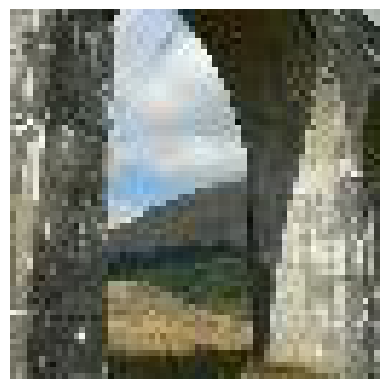

In [155]:
# Obtén un lote de datos del DataLoader (por ejemplo, el conjunto de entrenamiento)
for batch in dataloader['train']:
    images, labels = batch
    break  # Sal del bucle después de obtener el primer lote

# Supongamos que deseas mostrar la primera imagen del lote
image_to_show = images[0]  # Cambia el índice si deseas ver otra imagen

# Convierte el tensor de imagen de PyTorch a un arreglo NumPy
image_to_show = image_to_show.permute(1, 2, 0).numpy()  # Cambia el orden de las dimensiones

# Muestra la imagen utilizando Matplotlib
plt.imshow(image_to_show)
plt.axis('off')  # Oculta los ejes
plt.show()


### Modelo pre entrenado

Vamos a utilizar el modelo ResNeXt50 en este laboratorio. La elección de este modelo se debe a sus capacidades y rendimiento probados en tareas de visión por computadora. ResNeXt50 es conocido por su profundidad y habilidad para aprender representaciones de alta calidad de datos visuales complejos.

Dado que nuestro conjunto de datos ya está normalizado y listo para el entrenamiento, la elección de ResNeXt50 nos brinda una base sólida para abordar nuestra tarea de clasificación de imágenes con confianza.

In [156]:
# Cargar el modelo preentrenado resnext50_32x4d
model = models.resnext50_32x4d(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [157]:
class ModelCustom(torch.nn.Module):
  def __init__(self, n_outputs=200, pretrained=False, freeze=False):
    super().__init__()
    # descargamos resnext
    resnext = models.resnext50_32x4d(pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.resnext = nn.Sequential(*list(resnext.children())[:-1])
    if freeze:
      for param in self.resnext.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = nn.Linear(2048, n_outputs)

  def forward(self, x):
    x = self.resnext(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.resnext.parameters():
        param.requires_grad=True

In [136]:
# hacemos la prueba de que nuestro modelo funciona correctamente
model_custom = ModelCustom()
outputs = model_custom(torch.randn(64, 3, 224, 224))
outputs.shape

c:\Users\israe\anaconda3\envs\cuda_user\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([64, 200])

### Entreamiento

Hemos implementado la función `fit` para entrenar nuestro modelo, tal como mencionamos anteriormente. En este caso, estamos realizando un entrenamiento desde cero de nuestra red neuronal basada en el modelo ResNeXt50.

In [158]:
import numpy as np
from sklearn.metrics import accuracy_score

def fit(model, dataloader, epochs=5, lr_resnet=1e-4, lr_fc=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam([{'params': model.resnext.parameters(), 'lr': lr_resnet},{'params': model.fc.parameters(), 'lr': lr_fc}])
    criterion = nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y) 
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch 
                X, y = X.to(device), y.to(device) 
                y_hat = model(X) 
                loss = criterion(y_hat, y) 
                val_loss.append(loss.item()) 
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y) 
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [159]:
# Entrenando con finetuning (Congelando y Descongelando), entrenamos solo la capa de salida (fc) y luego todas las capas
model = ModelCustom(pretrained=True, freeze=True)

In [160]:
# entrenamos solo la capa de salida (fc) y luego todas las capas
fit(model, dataloader, epochs=5, lr_resnet=1e-4, lr_fc=0.001)
model.unfreeze()
fit(model, dataloader, epochs=5, lr_resnet=1e-4, lr_fc=0.001)

val_loss 3.08224 val_acc 0.36396: 100%|██████████| 40/40 [00:04<00:00,  8.08it/s]


Epoch 1/5 loss 3.30010 val_loss 3.08224 acc 0.31232 val_acc 0.36396


val_loss 3.13234 val_acc 0.35830: 100%|██████████| 40/40 [00:04<00:00,  8.09it/s]


Epoch 2/5 loss 2.85926 val_loss 3.13234 acc 0.38166 val_acc 0.35830


val_loss 3.13155 val_acc 0.37295: 100%|██████████| 40/40 [00:04<00:00,  8.06it/s]


Epoch 3/5 loss 2.71616 val_loss 3.13155 acc 0.40356 val_acc 0.37295


val_loss 3.14292 val_acc 0.37041: 100%|██████████| 40/40 [00:04<00:00,  8.10it/s]


Epoch 4/5 loss 2.62040 val_loss 3.14292 acc 0.41808 val_acc 0.37041


val_loss 3.11638 val_acc 0.37715: 100%|██████████| 40/40 [00:04<00:00,  8.06it/s]


Epoch 5/5 loss 2.53747 val_loss 3.11638 acc 0.43035 val_acc 0.37715


val_loss 1.69224 val_acc 0.59922: 100%|██████████| 40/40 [00:04<00:00,  8.28it/s]


Epoch 1/5 loss 2.05956 val_loss 1.69224 acc 0.52366 val_acc 0.59922


val_loss 1.79628 val_acc 0.59814: 100%|██████████| 40/40 [00:04<00:00,  8.03it/s]


Epoch 2/5 loss 1.26002 val_loss 1.79628 acc 0.68189 val_acc 0.59814


val_loss 1.84688 val_acc 0.59766: 100%|██████████| 40/40 [00:05<00:00,  7.23it/s]


Epoch 3/5 loss 0.89437 val_loss 1.84688 acc 0.76206 val_acc 0.59766


val_loss 1.87166 val_acc 0.61084: 100%|██████████| 40/40 [00:05<00:00,  7.88it/s]


Epoch 4/5 loss 0.64437 val_loss 1.87166 acc 0.82297 val_acc 0.61084


val_loss 1.95068 val_acc 0.60977: 100%|██████████| 40/40 [00:05<00:00,  7.90it/s]

Epoch 5/5 loss 0.49930 val_loss 1.95068 acc 0.86226 val_acc 0.60977


In [ ]:
# guardamos el modelo
torch.save(model.state_dict(), '/modelo_pre_entrenado_efficientnet-b0.pth')

In [ ]:
# cargamos el modelo
# definimos el modelo
model = models.resnext50_32x4d(pretrained=True)
model._fc = nn.Linear(2048, 200) # cambiamos a 200 clases de salida
model.load_state_dict(torch.load('/modelo_pre_entrenado_resnet50.pth'))
model.eval()